### Data Collection

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [2]:
# Read the data
data = pd.read_csv('../real_estate_data/Real_Estate_Sales_2001-2020.csv', low_memory=False)

# View the data
data.head()

Serial Number  List Year Date Recorded     Town          Address  \
0        2020177       2020    04/14/2021  Ansonia    323 BEAVER ST   
1        2020225       2020    05/26/2021  Ansonia   152 JACKSON ST   
2        2020348       2020    09/13/2021  Ansonia  230 WAKELEE AVE   
3        2020090       2020    12/14/2020  Ansonia      57 PLATT ST   
4         200500       2020    09/07/2021     Avon     245 NEW ROAD   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0        133000.0     248400.0       0.5354   Residential    Single Family   
1        110500.0     239900.0       0.4606   Residential     Three Family   
2        150500.0     325000.0       0.4630    Commercial              NaN   
3        127400.0     202500.0       0.6291   Residential       Two Family   
4        217640.0     400000.0       0.5441   Residential    Single Family   

  Non Use Code Assessor Remarks OPM remarks                    Location  
0          NaN              NaN         NaN  POINT (-73.06822 41.35014)  
1          NaN              NaN         NaN                         NaN  
2          NaN              NaN         NaN                         NaN  
3          NaN              NaN         NaN                         NaN  
4          NaN              NaN         NaN                         NaN

### Data Cleaning & Preparation

In [3]:
# Rename the columns
data.columns = [col.lower().replace(' ','_') for col in data.columns]

In [4]:
### Data type conversions

# serial_number - no change

# list_year - no change

# date_recorded --> no change

# town --> no change

# address --> no change

# assessed_value --> int
data['assessed_value'] = data['assessed_value'].astype(int)

# sale_amount --> int
data['sale_amount'] = data['sale_amount'].astype(int)

# sales_ratio - no change

# property_type - no change

# residential_type - no change

# non_use_code - no change

# assessor_remarks - no change

# opm_remarks - no change

# location - no change

# View converted data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   serial_number     997213 non-null  int64  
 1   list_year         997213 non-null  int64  
 2   date_recorded     997211 non-null  object 
 3   town              997213 non-null  object 
 4   address           997162 non-null  object 
 5   assessed_value    997213 non-null  int64  
 6   sale_amount       997213 non-null  int64  
 7   sales_ratio       997213 non-null  float64
 8   property_type     614767 non-null  object 
 9   residential_type  608904 non-null  object 
 10  non_use_code      289681 non-null  object 
 11  assessor_remarks  149864 non-null  object 
 12  opm_remarks       9934 non-null    object 
 13  location          197697 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 106.5+ MB


In [5]:
# Missing values
data.isnull().sum().sort_values(ascending=False)

opm_remarks         987279
assessor_remarks    847349
location            799516
non_use_code        707532
residential_type    388309
property_type       382446
address                 51
date_recorded            2
serial_number            0
list_year                0
town                     0
assessed_value           0
sale_amount              0
sales_ratio              0
dtype: int64

In [6]:
### Remove rows where missing values < 1% of data set

# Remove rows for 'address'
subset_1 = data.loc[data['address'].isnull()]
data.drop(index=subset_1.index, inplace=True)

# Remove rows for 'date_recorded'
subset_2 = data.loc[data['date_recorded'].isnull()]
data.drop(index=subset_2.index, inplace=True)

In [7]:
# Impute null values with 'None'
data['opm_remarks'].fillna('None', inplace=True)
data['assessor_remarks'].fillna('None', inplace=True)

# Impute null values with ''
data['non_use_code'].fillna('', inplace=True)
data['location'].fillna('', inplace=True)

# Impute null values with 'Other'
data['residential_type'].fillna('Other', inplace=True)
data['property_type'].fillna('Other', inplace=True)

In [8]:
# Create response variable
data.loc[data['assessed_value'] < data['sale_amount'], 'great_value'] = 1
data.loc[data['assessed_value'] >= data['sale_amount'], 'great_value'] = 0

# Convert response variable to integer
data['great_value'] = data['great_value'].astype(int)

In [9]:
# Determine the majority class
data['great_value'].value_counts(normalize=True)

1    0.866377
0    0.133623
Name: great_value, dtype: float64

### Feature Engineering - complete separately to prevent data leakage

In [10]:
# Define X and y
X = data.drop(columns='great_value')
y = data['great_value']

# Stratified 70:30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

#### Training Data

In [11]:
# Expand 'date_recorded' into 3 columns
X_train[['recorded_month', 'recorded_day', 'recorded_year']] = X_train['date_recorded'].str.split('/', expand=True)

# Drop 'date_recorded'
X_train.drop(columns='date_recorded', inplace=True)

# Convert X_train types for 3 columns
X_train['recorded_month'] = X_train['recorded_month'].astype(int)
X_train['recorded_day'] = X_train['recorded_day'].astype(int)
X_train['recorded_year'] = X_train['recorded_year'].astype(int)

In [12]:
# Frequency encode 'town'
fe_town = ce.CountEncoder(cols=['town'], normalize=True)
X_train['fe_town'] = fe_town.fit_transform(X_train['town'])

# Drop 'town'
X_train.drop(columns='town', inplace=True)

In [15]:
# Frequency encode 'property_type'
fe_ptype = ce.CountEncoder(cols=['property_type'], normalize=True)
X_train['fe_property_type'] = fe_ptype.fit_transform(X_train['property_type'])

# Drop 'property_type'
X_train.drop(columns='property_type', inplace=True)

In [21]:
# Frequency encode 'non_use_code'
fe_nuc = ce.CountEncoder(cols=['non_use_code'], normalize=True)
X_train['fe_non_use_code'] = fe_nuc.fit_transform(X_train['non_use_code'])

# Drop 'non_use_code'
X_train.drop(columns='non_use_code', inplace=True)

In [23]:
# Frequency encode 'opm_remarks'
fe_opmr = ce.CountEncoder(cols=['opm_remarks'], normalize=True)
X_train['fe_opm_remarks'] = fe_opmr.fit_transform(X_train['opm_remarks'])

# Drop 'opm_remarks'
X_train.drop(columns='opm_remarks', inplace=True)

In [18]:
# Get dummies for 'residential_type'
X_train = pd.get_dummies(data=X_train, columns=['residential_type'], drop_first=False)

In [34]:
# Binary encode 'assessor_remarks'
X_train.loc[X_train['assessor_remarks'] == 'None', 'be_assessor_remarks'] = 0
X_train.loc[X_train['assessor_remarks'] != 'None', 'be_assessor_remarks'] = 1

# Convert to int
X_train['be_assessor_remarks'] = X_train['be_assessor_remarks'].astype(int)

# Drop 'assessor_remarks'
X_train.drop(columns='assessor_remarks', inplace=True)

In [44]:
# Binary encode 'location'
X_train.loc[X_train['location'] == '', 'be_location'] = 0
X_train.loc[X_train['location'] != '', 'be_location'] = 1

# Convert to int
X_train['be_location'] = X_train['be_location'].astype(int)

# Drop 'location'
X_train.drop(columns='location', inplace=True)

In [42]:
# Drop 'address' - consider geo-encoding with latitude + longitude
X_train.drop(columns='address', inplace=True)

In [46]:
# View training data
X_train.head(3)

serial_number  list_year  assessed_value  sale_amount  sales_ratio  \
913694          18257       2018          172760       400000     0.431900   
941117          18745       2018          284340       422000     0.673700   
390364          50031       2005          209930       365000     0.575151   

        recorded_month  recorded_day  recorded_year   fe_town  \
913694              12            27           2018  0.018868   
941117               9            10           2019  0.012478   
390364              10             7           2005  0.016844   

        fe_property_type  residential_type_Condo  \
913694          0.382877                       0   
941117          0.382877                       0   
390364          0.382877                       0   

        residential_type_Four Family  residential_type_Other  \
913694                             0                       1   
941117                             0                       1   
390364                             0                       1   

        residential_type_Single Family  residential_type_Three Family  \
913694                               0                              0   
941117                               0                              0   
390364                               0                              0   

        residential_type_Two Family  fe_non_use_code  fe_opm_remarks  \
913694                            0          0.70997        0.990019   
941117                            0          0.70997        0.990019   
390364                            0          0.70997        0.990019   

        be_assessor_remarks  be_location  
913694                    0            0  
941117                    0            0  
390364                    0            0

#### Testing Data

In [13]:
# Expand 'date_recorded' into 3 columns
X_test[['recorded_month', 'recorded_day', 'recorded_year']] = X_test['date_recorded'].str.split('/', expand=True)

# Drop 'date_recorded'
X_test.drop(columns='date_recorded', inplace=True)

# Convert X_test types for 3 columns
X_test['recorded_month'] = X_test['recorded_month'].astype(int)
X_test['recorded_day'] = X_test['recorded_day'].astype(int)
X_test['recorded_year'] = X_test['recorded_year'].astype(int)

In [14]:
# Frequency encode 'town'
X_test['fe_town'] = fe_town.transform(X_test['town'])

# Drop 'town'
X_test.drop(columns='town', inplace=True)

In [16]:
# Frequency encode 'property_type'
X_test['fe_property_type'] = fe_ptype.transform(X_test['property_type'])

# Drop 'property_type'
X_test.drop(columns='property_type', inplace=True)

In [22]:
# Frequency encode 'non_use_code'
X_test['fe_non_use_code'] = fe_nuc.transform(X_test['non_use_code'])

# Drop 'non_use_code'
X_test.drop(columns='non_use_code', inplace=True)

In [24]:
# Frequency encode 'opm_remarks'
X_test['fe_opm_remarks'] = fe_opmr.transform(X_test['opm_remarks'])

# Drop 'opm_remarks'
X_test.drop(columns='opm_remarks', inplace=True)

In [19]:
# Get dummies for 'residential_type'
X_test = pd.get_dummies(data=X_test, columns=['residential_type'], drop_first=False)

In [36]:
# Binary encode 'assessor_remarks'
X_test.loc[X_test['assessor_remarks'] == 'None', 'be_assessor_remarks'] = 0
X_test.loc[X_test['assessor_remarks'] != 'None', 'be_assessor_remarks'] = 1

# Convert to int
X_test['be_assessor_remarks'] = X_test['be_assessor_remarks'].astype(int)

# Drop 'assessor_remarks'
X_test.drop(columns='assessor_remarks', inplace=True)

In [45]:
# Binary encode 'location'
X_test.loc[X_test['location'] == '', 'be_location'] = 0
X_test.loc[X_test['location'] != '', 'be_location'] = 1

# Convert to int
X_test['be_location'] = X_test['be_location'].astype(int)

# Drop 'location'
X_test.drop(columns='location', inplace=True)

In [43]:
# Drop 'address' - consider geo-encoding with latitude + longitude
X_test.drop(columns='address', inplace=True)

In [47]:
# View testing data
X_test.head(3)

serial_number  list_year  assessed_value  sale_amount  sales_ratio  \
813518          16421       2016          225700       336000     0.671726   
260467          42002       2004          151550       240000     0.631458   
164076          20788       2002          241430       535000     0.451271   

        recorded_month  recorded_day  recorded_year   fe_town  \
813518               8            10           2017  0.008188   
260467               4            28           2005  0.034241   
164076               3            25           2003  0.024149   

        fe_property_type  residential_type_Condo  \
813518          0.403087                       0   
260467          0.382877                       0   
164076          0.382877                       0   

        residential_type_Four Family  residential_type_Other  \
813518                             0                       0   
260467                             0                       1   
164076                             0                       1   

        residential_type_Single Family  residential_type_Three Family  \
813518                               1                              0   
260467                               0                              0   
164076                               0                              0   

        residential_type_Two Family  fe_non_use_code  fe_opm_remarks  \
813518                            0          0.70997        0.990019   
260467                            0          0.70997        0.990019   
164076                            0          0.70997        0.990019   

        be_assessor_remarks  be_location  
813518                    0            0  
260467                    0            0  
164076                    0            0

### EDA on Training Data

In [51]:
# Combine X_train and y_train to create full training data
train = X_train.join(y_train)

# View training data
train.head()

serial_number  list_year  assessed_value  sale_amount  sales_ratio  \
913694          18257       2018          172760       400000     0.431900   
941117          18745       2018          284340       422000     0.673700   
390364          50031       2005          209930       365000     0.575151   
907694         180118       2018          157170       200000     0.785800   
376844          50241       2005          276780       469000     0.590149   

        recorded_month  recorded_day  recorded_year   fe_town  \
913694              12            27           2018  0.018868   
941117               9            10           2019  0.012478   
390364              10             7           2005  0.016844   
907694               4             1           2019  0.003746   
376844               6            22           2006  0.005980   

        fe_property_type  ...  residential_type_Four Family  \
913694          0.382877  ...                             0   
941117          0.382877  ...                             0   
390364          0.382877  ...                             0   
907694          0.403087  ...                             0   
376844          0.382877  ...                             0   

        residential_type_Other  residential_type_Single Family  \
913694                       1                               0   
941117                       1                               0   
390364                       1                               0   
907694                       0                               1   
376844                       1                               0   

        residential_type_Three Family  residential_type_Two Family  \
913694                              0                            0   
941117                              0                            0   
390364                              0                            0   
907694                              0                            0   
376844                              0                            0   

        fe_non_use_code  fe_opm_remarks  be_assessor_remarks  be_location  \
913694          0.70997        0.990019                    0            0   
941117          0.70997        0.990019                    0            0   
390364          0.70997        0.990019                    0            0   
907694          0.70997        0.990019                    0            0   
376844          0.70997        0.990019                    0            0   

        great_value  
913694            1  
941117            1  
390364            1  
907694            1  
376844            1  

[5 rows x 21 columns]

In [48]:
# Dimensions of X_train
X_train.shape

(698013, 20)

In [52]:
# Dimensions of y_train
y_train.shape

(698013,)

In [53]:
# Summary statistics
train.describe().T

count           mean           std  \
serial_number                   698013.0  433935.804832  6.806673e+06   
list_year                       698013.0    2010.190022  6.234434e+00   
assessed_value                  698013.0  278217.306754  1.413304e+06   
sale_amount                     698013.0  393568.771968  6.271524e+06   
sales_ratio                     698013.0      11.899421  2.127895e+03   
recorded_month                  698013.0       6.813014  3.235486e+00   
recorded_day                    698013.0      15.824748  9.409972e+00   
recorded_year                   698013.0    2010.941063  6.244335e+00   
fe_town                         698013.0       0.012236  8.763161e-03   
fe_property_type                698013.0       0.324883  1.323145e-01   
residential_type_Condo          698013.0       0.118296  3.229583e-01   
residential_type_Four Family    698013.0       0.002414  4.907312e-02   
residential_type_Other          698013.0       0.388718  4.874593e-01   
residential_type_Single Family  698013.0       0.446536  4.971337e-01   
residential_type_Three Family   698013.0       0.014209  1.183513e-01   
residential_type_Two Family     698013.0       0.029828  1.701114e-01   
fe_non_use_code                 698013.0       0.512999  3.084177e-01   
fe_opm_remarks                  698013.0       0.980139  9.839729e-02   
be_assessor_remarks             698013.0       0.150163  3.572318e-01   
be_location                     698013.0       0.198142  3.986004e-01   
great_value                     698013.0       0.866376  3.402477e-01   

                                        min            25%            50%  \
serial_number                     81.000000   30461.000000   70316.000000   
list_year                       2001.000000    2004.000000    2010.000000   
assessed_value                     0.000000   87680.000000  138390.000000   
sale_amount                        0.000000  140000.000000  225000.000000   
sales_ratio                        0.000000       0.486761       0.624849   
recorded_month                     1.000000       4.000000       7.000000   
recorded_day                       1.000000       7.000000      16.000000   
recorded_year                   1999.000000    2005.000000    2011.000000   
fe_town                            0.000252       0.005549       0.009261   
fe_property_type                   0.000006       0.382877       0.382877   
residential_type_Condo             0.000000       0.000000       0.000000   
residential_type_Four Family       0.000000       0.000000       0.000000   
residential_type_Other             0.000000       0.000000       0.000000   
residential_type_Single Family     0.000000       0.000000       0.000000   
residential_type_Three Family      0.000000       0.000000       0.000000   
residential_type_Two Family        0.000000       0.000000       0.000000   
fe_non_use_code                    0.000001       0.059837       0.709970   
fe_opm_remarks                     0.000001       0.990019       0.990019   
be_assessor_remarks                0.000000       0.000000       0.000000   
be_location                        0.000000       0.000000       0.000000   
great_value                        0.000000       1.000000       1.000000   

                                          75%           max  
serial_number                   151800.000000  2.000500e+09  
list_year                         2016.000000  2.020000e+03  
assessed_value                  225400.000000  1.389588e+08  
sale_amount                     364900.000000  5.000000e+09  
sales_ratio                          0.785435  1.226420e+06  
recorded_month                       9.000000  1.200000e+01  
recorded_day                        24.000000  3.100000e+01  
recorded_year                     2017.000000  2.021000e+03  
fe_town                              0.017490  3.424148e-02  
fe_property_type                     0.403087  4.030870e-01  
residential_type_Condo               0.000000  1.00

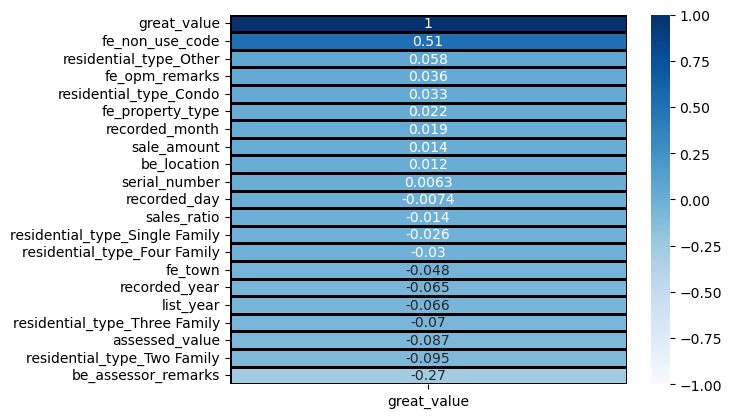

In [54]:
# Heat map of data
sns.heatmap(train.select_dtypes(include='number').corr()[['great_value']] \
            .sort_values(by='great_value', ascending=False), cmap='Blues', \
            vmin=-1, vmax=1, annot=True, linecolor='black', linewidths=2);

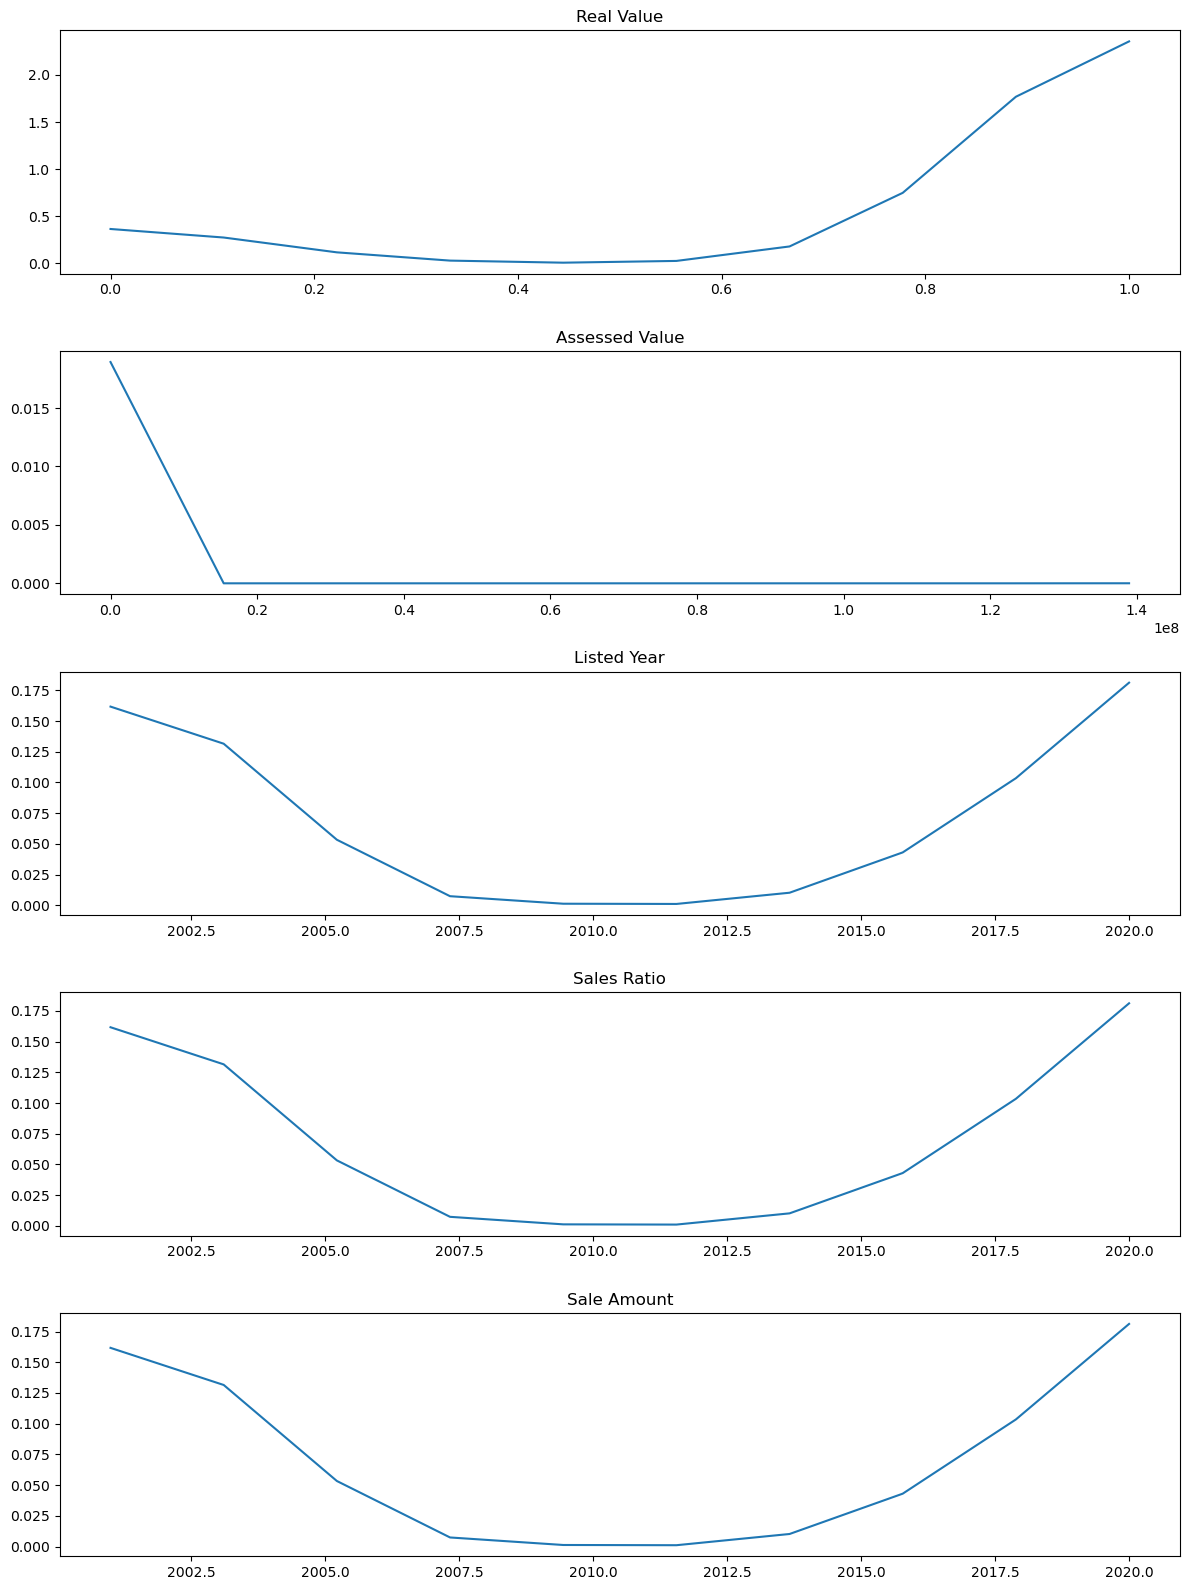

In [55]:
# Set the kernel bandwidth
sigma_1 = math.sqrt(statistics.variance(train['great_value']))
h1 = 1.06 * sigma_1 * 90**(-1/5)

sigma_2 = math.sqrt(statistics.variance(train['assessed_value']))
h2 = 1.06 * sigma_1 * 90**(-1/5)

sigma_3 = math.sqrt(statistics.variance(train['list_year']))
h3 = 1.06 * sigma_1 * 90**(-1/5)

sigma_4 = math.sqrt(statistics.variance(train['sales_ratio']))
h4 = 1.06 * sigma_1 * 90**(-1/5)

sigma_5 = math.sqrt(statistics.variance(train['sale_amount']))
h5 = 1.06 * sigma_1 * 90**(-1/5)

# 1-D KDE
fig, ax = plt.subplots(5, figsize=(12,16))

arr_rv = np.array(train['great_value'])
kde_rv = KernelDensity(bandwidth=h1, kernel='gaussian')
kde_rv.fit(arr_rv.reshape(-1,1))
xval_1 = np.linspace(np.min(arr_rv), np.max(arr_rv), 10)
logdens_1 = kde_rv.score_samples(xval_1.reshape(-1,1))
dens_1 = np.exp(logdens_1)
ax[0].plot(xval_1, dens_1)
ax[0].set_title('Real Value')

arr_av = np.array(train['assessed_value'])
kde_av = KernelDensity(bandwidth=h2, kernel='gaussian')
kde_av.fit(arr_av.reshape(-1,1))
xval_2 = np.linspace(np.min(arr_av), np.max(arr_av), 10)
logdens_2 = kde_av.score_samples(xval_2.reshape(-1,1))
dens_2 = np.exp(logdens_2)
ax[1].plot(xval_2, dens_2)
ax[1].set_title('Assessed Value')

arr_ly = np.array(train['list_year'])
kde_ly = KernelDensity(bandwidth=h3, kernel='gaussian')
kde_ly.fit(arr_ly.reshape(-1,1))
xval_3 = np.linspace(np.min(arr_ly), np.max(arr_ly), 10)
logdens_3 = kde_ly.score_samples(xval_3.reshape(-1,1))
dens_3 = np.exp(logdens_3)
ax[2].plot(xval_3, dens_3)
ax[2].set_title('Listed Year')

arr_sr = np.array(train['list_year'])
kde_sr = KernelDensity(bandwidth=h4, kernel='gaussian')
kde_sr.fit(arr_sr.reshape(-1,1))
xval_4 = np.linspace(np.min(arr_sr), np.max(arr_sr), 10)
logdens_4 = kde_sr.score_samples(xval_4.reshape(-1,1))
dens_4 = np.exp(logdens_4)
ax[3].plot(xval_4, dens_4)
ax[3].set_title('Sales Ratio')

arr_sa = np.array(train['list_year'])
kde_sa = KernelDensity(bandwidth=h5, kernel='gaussian')
kde_sa.fit(arr_sa.reshape(-1,1))
xval_5 = np.linspace(np.min(arr_sa), np.max(arr_sa), 10)
logdens_5 = kde_sa.score_samples(xval_5.reshape(-1,1))
dens_5 = np.exp(logdens_5)
ax[4].plot(xval_5, dens_5)
ax[4].set_title('Sale Amount')

plt.tight_layout()
plt.show()

In [ ]:
# Box plots
fig, ax = plt.subplots(5, figsize=(8,8))

ax[0].boxplot(x=data['real_value'], vert=False)
ax[1].boxplot(x=data['assessed_value'], vert=False)
ax[2].boxplot(x=data['list_year'], vert=False)
ax[3].boxplot(x=data['sales_ratio'], vert=False)
ax[4].boxplot(x=data['sale_amount'], vert=False)

plt.tight_layout()
plt.show()

In [ ]:
plt.barh(y=data['date_recorded'], width=data['assessed_value'].sort_values(ascending=True))

### References

"Boxplots". Matplotlib.org, https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html. Accessed 11 Oct. 2023.

"How do I find numeric columns in Pandas?". Stackoverflow, https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas. Accessed 11 Oct. 2023.

"How to Split One Column into Multiple Columns in Pandas DataFrame". Saturn Cloud, https://saturncloud.io/blog/how-to-split-one-column-into-multiple-columns-in-pandas-dataframe/. Accessed 11 Oct. 2023.

"matplotlib.pyplot.boxplot". Matplotlib.org, https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html. Accessed 11 Oct. 2023.